In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

from kid_readout.measurement.io import npy
from kid_readout.measurement import basic, plot_basic

In [124]:
save_directory = '/home/flanigan/temp/'
save_example_hot_and_cold = True
save_full_hot_and_cold_scans = True
save_wide_sweep_180_mK_real_and_fake = True

In [2]:
npd_hot = npy.NumpyDirectory('/data/readout/2017-12-06_153018_scan.npd/')
npd_cold = npy.NumpyDirectory('/data/readout/2017-12-06_184200_scan.npd')

In [3]:
scan_hot = npd_hot.Scan0
snaps_hot = [npd_hot.read(name) for name in npd_hot.node_names() if name.startswith('ADCSnap')]
scan_cold = npd_cold.Scan0
snaps_cold = [npd_cold.read(name) for name in npd_cold.node_names() if name.startswith('ADCSnap')]

# Temperatures

In [5]:
package_color = 'C0'
eccosorb_color = 'C1'
stepper_color = 'C2'

def time_and_temperatures(scan):
    start_epoch = scan.start_epoch()
    time = [sa.start_epoch() - start_epoch for sa in scan.sweep_arrays]
    package = [sa.state.temperature.package_ruox4550_temperature for sa in scan.sweep_arrays]
    eccosorb = [sa.state.temperature.eccosorb_diode_temperature for sa in scan.sweep_arrays]
    stepper = [sa.state.temperature.stepper_diode_temperature for sa in scan.sweep_arrays]
    return time, package, eccosorb, stepper

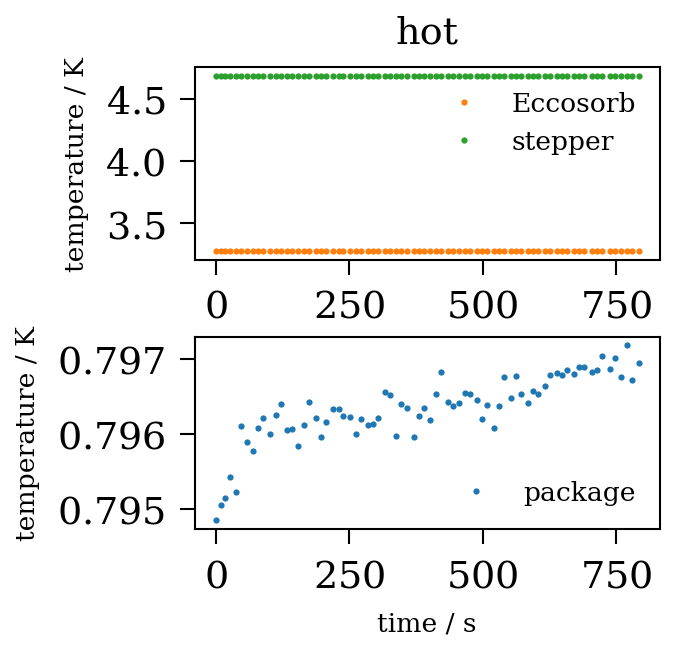

In [6]:
fig, (diode_ax, package_ax) = plt.subplots(2, 1, figsize=(2, 2), gridspec_kw={'hspace': 0.4})
diode_ax.set_ylabel('temperature / K', fontsize='xx-small')
package_ax.set_ylabel('temperature / K', fontsize='xx-small')
package_ax.set_xlabel('time / s', fontsize='xx-small')

diode_ax.set_title('hot')
time, package, eccosorb, stepper = time_and_temperatures(scan_hot)
package_ax.plot(time, package, '.', color=package_color, label='package')
diode_ax.plot(time, eccosorb, '.', color=eccosorb_color, label='Eccosorb')
diode_ax.plot(time, stepper, '.', color=stepper_color, label='stepper')

package_ax.legend(fontsize='xx-small')
diode_ax.legend(fontsize='xx-small')

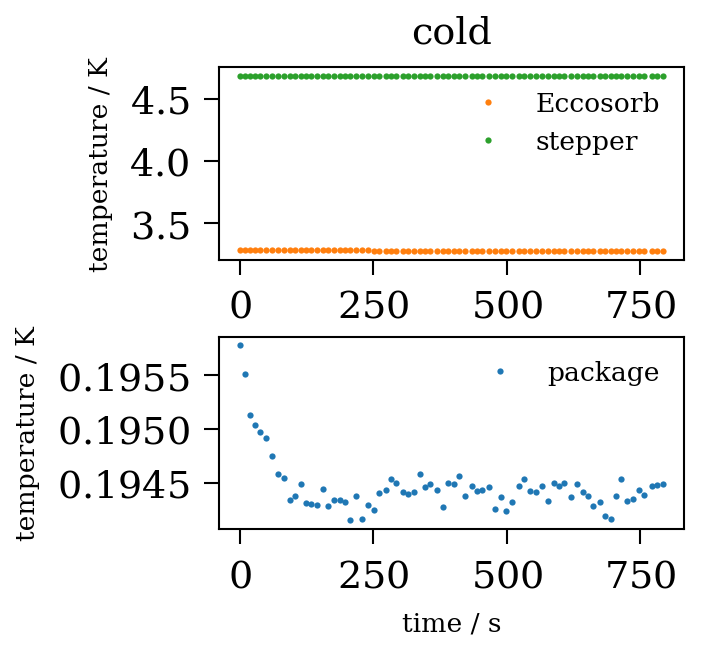

In [7]:
fig, (diode_ax, package_ax) = plt.subplots(2, 1, figsize=(2, 2), gridspec_kw={'hspace': 0.4})
diode_ax.set_ylabel('temperature / K', fontsize='xx-small')
package_ax.set_ylabel('temperature / K', fontsize='xx-small')
package_ax.set_xlabel('time / s', fontsize='xx-small')

diode_ax.set_title('cold')
time, package, eccosorb, stepper = time_and_temperatures(scan_cold)
package_ax.plot(time, package, '.', color=package_color, label='package')
diode_ax.plot(time, eccosorb, '.', color=eccosorb_color, label='Eccosorb')
diode_ax.plot(time, stepper, '.', color=stepper_color, label='stepper')

package_ax.legend(fontsize='xx-small')
diode_ax.legend(fontsize='xx-small')

# All data

In [8]:
def dac_normalization(dac_attenuation):
    """Multiply raw S21 data by the returned number to normalize it to 0 dB DAC attenuation."""
    return 10 ** (dac_attenuation / 20)

def fft_gain_normalization(fft_shift_register):
    """Multiply raw S21 data by the returned number to normalize it to 0 FFT gain."""
    fft_shift_string = "{:b}".format(fft_shift_register)
    num_zeros = fft_shift_string.count('0')
    return 2 ** -num_zeros

def total_normalization(roach_state):
    return dac_normalization(roach_state.dac_attenuation) * fft_gain_normalization(roach_state.fft_shift_register)

In [65]:
frequency_hot, amplitude_hot, smoothed_hot = scan_hot.stitch()
frequency_cold, amplitude_cold, smoothed_cold = scan_cold.stitch()
poly_hot = np.polyval(np.polyfit(frequency_hot, smoothed_hot, 2), frequency_hot)
poly_cold = np.polyval(np.polyfit(frequency_cold, smoothed_cold, 2), frequency_cold)

In [115]:
raw_color_hot = 'xkcd:light red'
smooth_color_hot = 'red'
raw_color_cold = 'xkcd:light blue'
smooth_color_cold = 'blue'

color_nominal = 'lightgray'
color_fake = 'brown'
color_real = 'green'

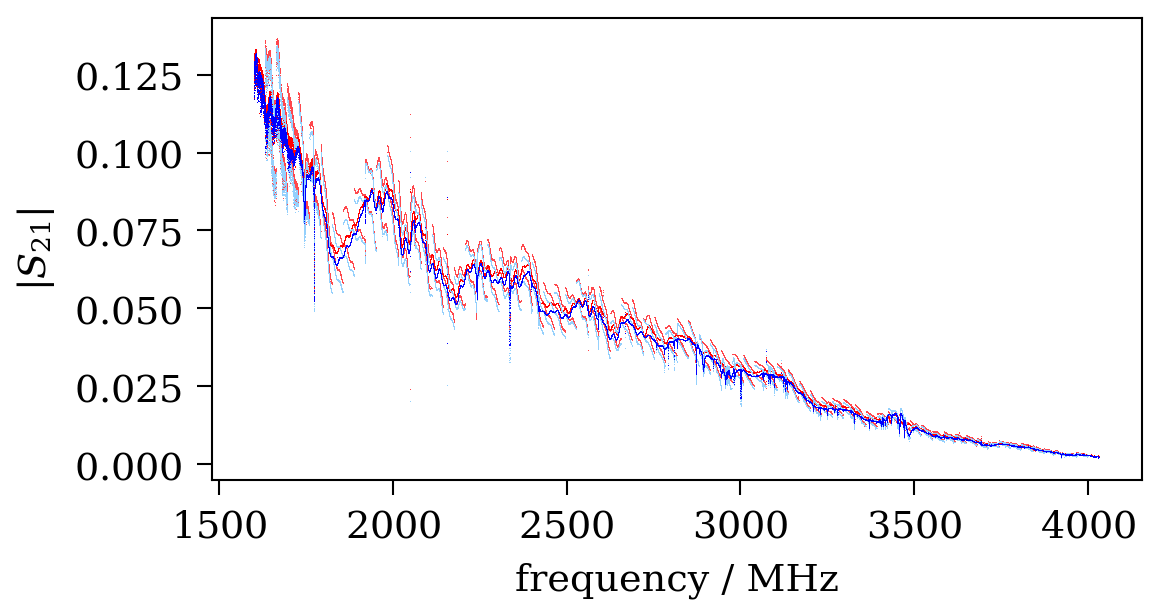

In [58]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xlabel('frequency / MHz', rotation='horizontal')
ax.set_ylabel('$|S_{21}|$', rotation='vertical')
ax.set_yscale('linear')
ax.set_yscale('linear')

for sa in scan_hot.sweep_arrays:
    ax.plot(sa.frequency_MHz,
            np.abs(sa.s21_point),
            ',', color=raw_color_hot)
ax.plot(1e-6 * frequency_hot, amplitude_hot, ',', color=smooth_color_hot)

for sa in scan_cold.sweep_arrays:
    ax.plot(sa.frequency_MHz,
            np.abs(sa.s21_point),
            ',', color=raw_color_cold)
ax.plot(1e-6 * frequency_cold, amplitude_cold, ',', color=smooth_color_cold)


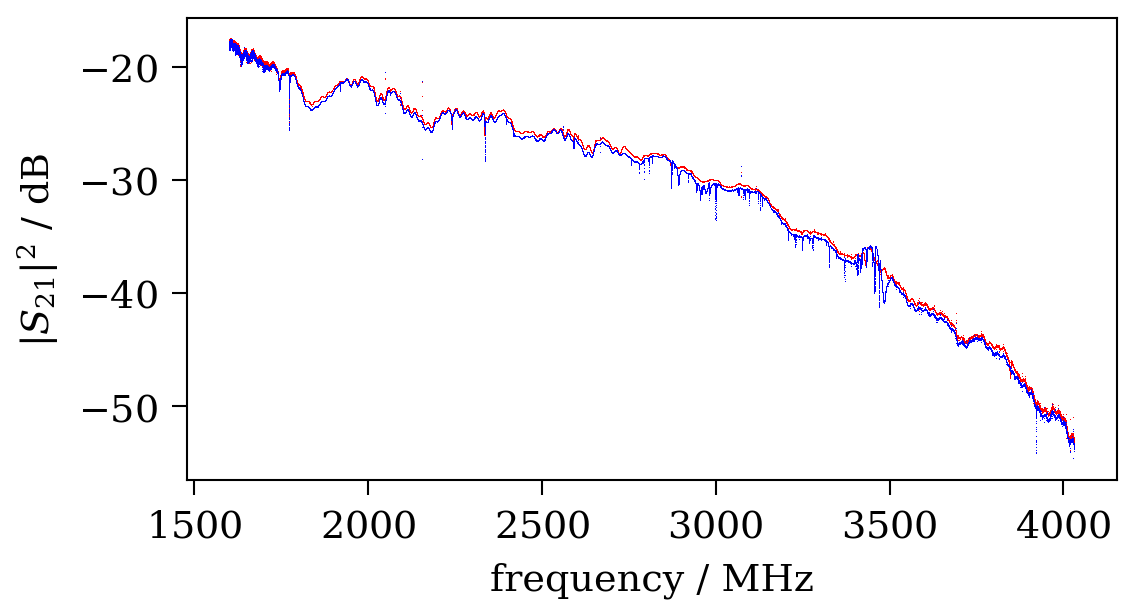

In [59]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xlabel('frequency / MHz', rotation='horizontal')
ax.set_ylabel('$|S_{21}|^2$ / dB', rotation='vertical')
ax.set_yscale('linear')
ax.set_yscale('linear')

ax.plot(1e-6 * frequency_hot, 20 * np.log10(amplitude_hot), ',', color=smooth_color_hot)
ax.plot(1e-6 * frequency_cold, 20 * np.log10(amplitude_cold), ',', color=smooth_color_cold)


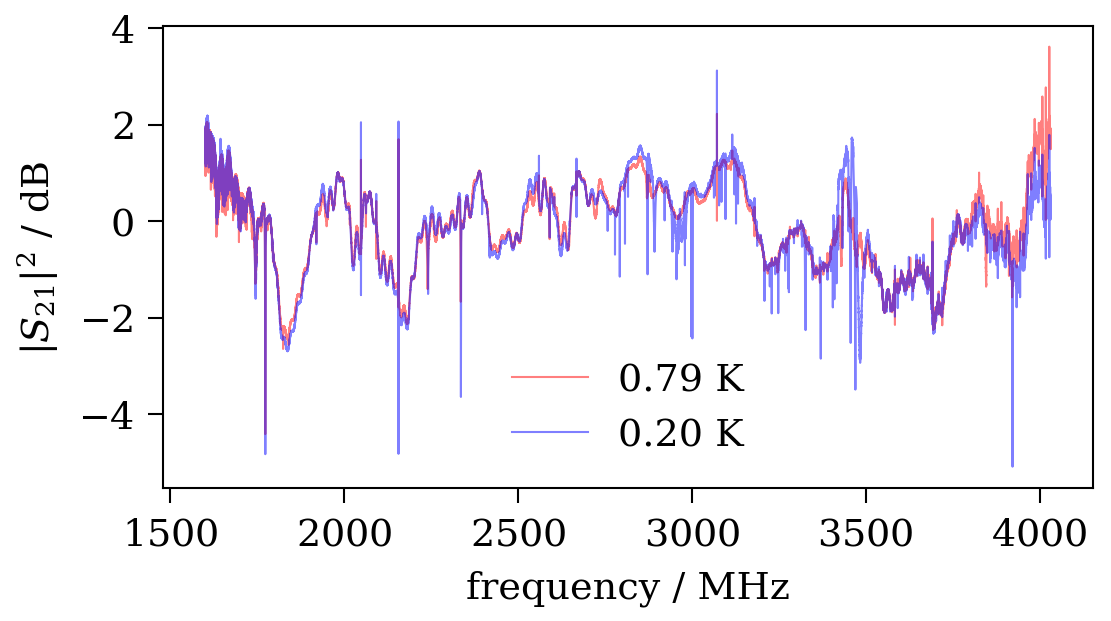

In [87]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xlabel('frequency / MHz', rotation='horizontal')
ax.set_ylabel('$|S_{21}|^2$ / dB', rotation='vertical')
ax.set_yscale('linear')
ax.set_yscale('linear')

ax.plot(1e-6 * frequency_hot, 20 * np.log10(amplitude_hot / poly_hot),
        '-', markersize=1, color=smooth_color_hot, alpha=0.5,
        label='{:.2f} K'.format(scan_hot.sweep_arrays[0].state.temperature.package_ruox4550_temperature))
ax.plot(1e-6 * frequency_cold, 20 * np.log10(amplitude_cold / poly_cold),
        '-', markersize=1, color=smooth_color_cold, alpha=0.5,
        label='{:.2f} K'.format(scan_cold.sweep_arrays[0].state.temperature.package_ruox4550_temperature))
ax.legend()

if save_full_hot_and_cold_scans:
    fig.savefig(save_directory + 'full_hot_and_cold_scans.pdf')

In [97]:
def f_and_s21(scan):
    f = scan.frequency
    # s21 = scan.s21_point_foreground
    s21 = np.concatenate([sa.s21_point_foreground for sa in scan.sweep_arrays])  
    order = f.argsort()
    return f[order], s21[order]

In [98]:
f_hot, s21_hot = f_and_s21(scan_hot)
f_cold, s21_cold = f_and_s21(scan_cold)

In [105]:
f_nominal = 1e6 * np.concatenate([np.linspace(2542, 2634, 23),
                                  np.linspace(2664, 2756, 23),
                                  np.linspace(2786, 2878, 23),
                                  np.linspace(2908, 3000, 23)])

# Real and fake are determined from this notebook
f_fake = 1e6 * np.array([
    1744, 1772, 1920, 2062, 2186, 2240, 2335, 2591, 2872, 3248, 3433, 3850, 3922
])

# New row means a gap of at least 20 MHz
f_real = 1e6 * np.array([
    2396,
    2676,
    2757,
    2778, 2792, 2805, 2806, 2816, 
    2881, 2892, 
    2921, 2931, 2944, 2946, 2955, 2958, 2961, 2965, 2980, 2982, 2995, 2998, 3001,
    3062, 3064, 3066, 3078, 3081, 3085, 3088, 3092, 3093, 3096, 3097, 3098, 3122, 3127, 3132, 3139, 3149,
    3169, 3188,
    3209, 3224, 3229,
    3251, 3263, 3268, 3277, 3278, 3279, 3293,
    3316, 3325, 3327,
    3347,
    3371,
    3398, 3405, 3410, 3415, 3421,
    3442, 3451, 3456, 3470
])

In [122]:
print("Nominal: {:d}".format(f_nominal.size))
print("Real: {:d}".format(f_real.size))
print("Fake: {:d}".format(f_fake.size))

Nominal: 92
Real: 66
Fake: 13


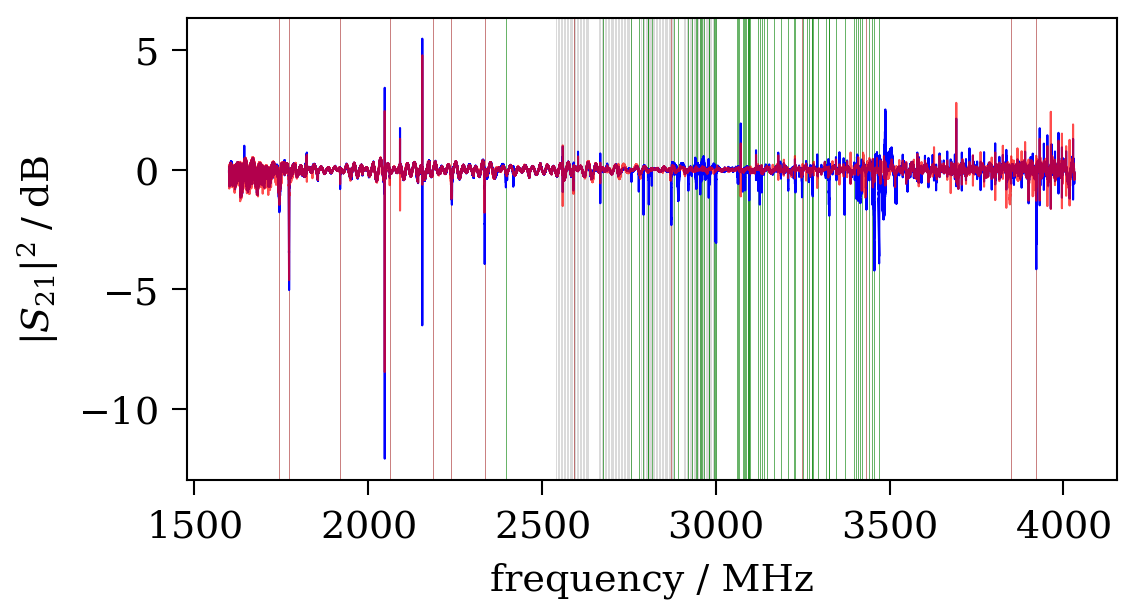

In [125]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xlabel('frequency / MHz')
ax.set_ylabel('$|S_{21}|^2 \; / \; \mathrm{dB}$')
for f in f_nominal:
    ax.axvline(1e-6 * f, color=color_nominal, alpha=1, linewidth=0.2)
for f in f_fake:
    ax.axvline(1e-6 * f, color=color_fake, alpha=0.7, linewidth=0.2)
for f in f_real:
    ax.axvline(1e-6 * f, color=color_real, alpha=0.7, linewidth=0.2)
ax.plot(1e-6 * f_cold,
        20 * np.log10(np.abs(s21_cold)),
        color=smooth_color_cold, alpha=1)
ax.plot(1e-6 * f_hot,
        20 * np.log10(np.abs(s21_hot)),
        color=smooth_color_hot, alpha=0.7)


if save_wide_sweep_180_mK_real_and_fake:
    fig.savefig(save_directory + 'wide_sweep_180_mK_real_and_fake.pdf')
    fig.savefig(save_directory + 'wide_sweep_180_mK_real_and_fake.png')

# Individual sweeps

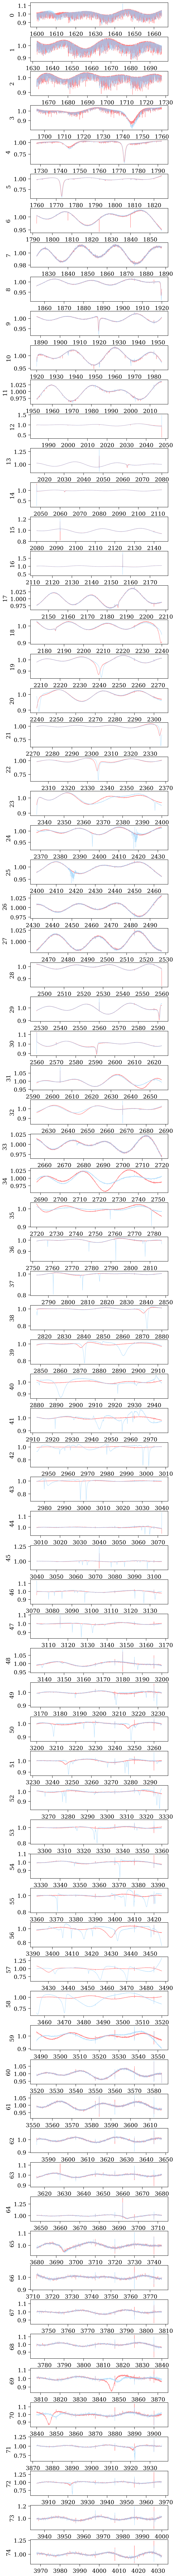

In [41]:
num_subplots = len(scan_cold.sweep_arrays)
fig, axes = plt.subplots(num_subplots, 1, figsize=(4, 1 * num_subplots),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
for index, (hot, cold, ax) in enumerate(zip(scan_hot.sweep_arrays, scan_cold.sweep_arrays, axes)):
    ax.plot(hot.frequency_MHz, np.abs(hot.s21_point_foreground), color=raw_color_hot, alpha=0.7)
    ax.plot(cold.frequency_MHz, np.abs(cold.s21_point_foreground), color=raw_color_cold, alpha=0.7)
    ax.set_ylabel(str(index), rotation='horizontal')

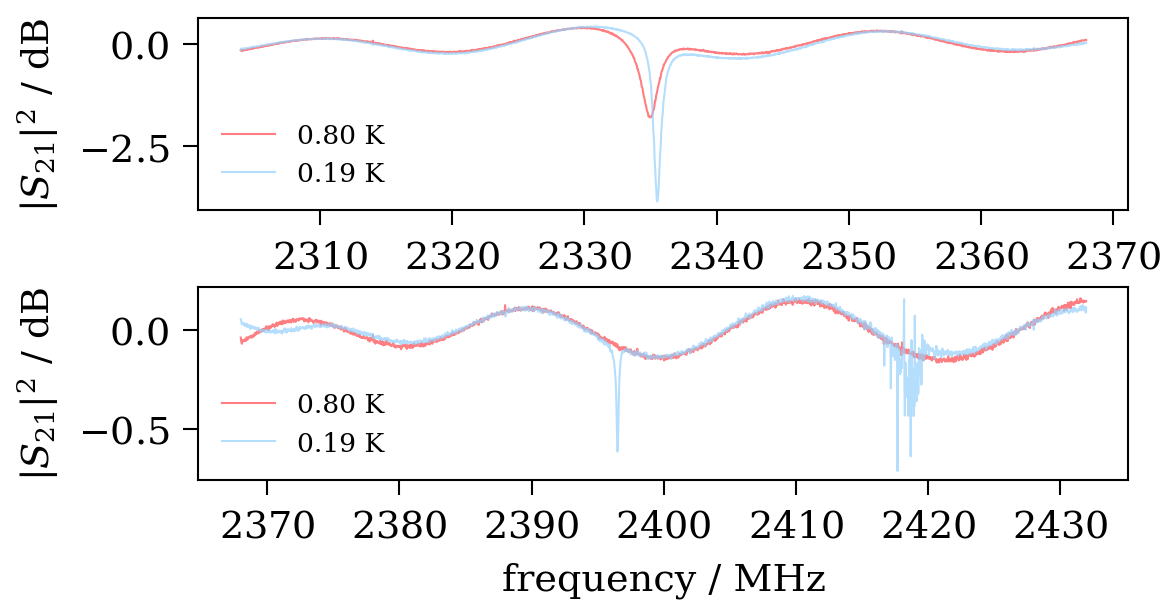

In [47]:
index_fake = 22
index_real = 24
fig, (ax_fake, ax_real) = plt.subplots(2, 1, figsize=(4, 2), gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
ax_fake.set_ylabel('$|S_{21}|^2$ / dB')
ax_real.set_ylabel('$|S_{21}|^2$ / dB')
ax_real.set_xlabel('frequency / MHz')

fake_hot = scan_hot.sweep_arrays[index_fake]
fake_cold = scan_cold.sweep_arrays[index_fake]
real_hot = scan_hot.sweep_arrays[index_real]
real_cold = scan_cold.sweep_arrays[index_real]

ax_fake.plot(fake_hot.frequency_MHz, 20 * np.log10(np.abs(fake_hot.s21_point_foreground)),
             color=raw_color_hot, alpha=0.7,
             label='{:.2f} K'.format(fake_hot.state.temperature.package_ruox4550_temperature))
ax_fake.plot(fake_cold.frequency_MHz, 20 * np.log10(np.abs(fake_cold.s21_point_foreground)),
             color=raw_color_cold, alpha=0.7,
             label='{:.2f} K'.format(fake_cold.state.temperature.package_ruox4550_temperature))
ax_real.plot(real_hot.frequency_MHz, 20 * np.log10(np.abs(real_hot.s21_point_foreground)),
             color=raw_color_hot, alpha=0.7,
             label='{:.2f} K'.format(real_hot.state.temperature.package_ruox4550_temperature))
ax_real.plot(real_cold.frequency_MHz, 20 * np.log10(np.abs(real_cold.s21_point_foreground)),
             color=raw_color_cold, alpha=0.7,
             label='{:.2f} K'.format(real_cold.state.temperature.package_ruox4550_temperature))

ax_fake.legend(fontsize='xx-small')
ax_real.legend(fontsize='xx-small')

if save_example_hot_and_cold:
    fig.savefig(save_directory + 'example_hot_and_cold.pdf')